# Image Search  

## Описание проекта
Целью проекта является разработка демонстрационной версии поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

### Проект разделен на следующие этапы:  
1. Загрузка данных;  
2. Исследовательский анализ данных;  
3. Фильтрация данных;
4. Векторизация изображений;  
5. Векторизация текстов;  
6. Объединение векторов;  
7. Обучение модели предсказания соответствия;  
8. Тестирование лучшей модели;  
9. Применение модели CLIP;
10. Вывод по проекту.  

## 1. Загрузка данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нам необходимо эти оценки агрегировать.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Изучим оба вида оценок и выберем способ их агрегации.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import requests
from io import BytesIO
import os

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

import torch
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.container import Sequential
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler

from sentence_transformers import SentenceTransformer, util

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

d:\Programs\Anaconda\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('whitegrid',
             {'axes.facecolor': '0.85',
              'axes.edgecolor': '0.15',
              'grid.color': '0.7',
              'figure.facecolor': '0.9'})

Определим глобальные переменные

In [3]:
DATA_MODES = ['train', 'valid', 'test', 
              'transform_image', 'transform_query', 
              'display']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

RANDOM_STATE = 42

DATA_PATH_LOCAL = '../data/data_image_search'
DATA_PATH_GLOBAL = ''
CLIP_PATH = 'D:\My_Code\image_search\clip_model'

Загрузим изображение дисклеймера

In [4]:
url = 'https://mst63.ru/wp-content/uploads/0/a/1/0a16d03196371831c6059c812ed171f9.jpeg'
try:
    image = Image.open('Disc.jpg') #Этот дисклеймер работает только локально
except:    
    response = requests.get(url) 
    image = Image.open(BytesIO(response.content)) 

image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
DISC = transform(image)

Загрузим данные

In [5]:
try:
    train_dataset = pd.read_csv(os.path.join(DATA_PATH_LOCAL, 'train_dataset.csv'))
    crowd = pd.read_table(os.path.join(DATA_PATH_LOCAL, 'CrowdAnnotations.tsv'), 
                          header=None, names=['image', 'query_id', 'ratio', 'respond', 'mismatch'])
    expert = pd.read_table(os.path.join(DATA_PATH_LOCAL, 'ExpertAnnotations.tsv'), 
                           header=None, names=['image', 'query_id', 'e1', 'e2', 'e3'])
    test_queries = pd.read_csv(os.path.join(DATA_PATH_LOCAL, 'test_queries.csv'), sep='|').drop('Unnamed: 0', axis=1)

except:
    train_dataset = pd.read_csv(os.path.join(DATA_PATH_GLOBAL, 'train_dataset.csv'))
    crowd = pd.read_table(os.path.join(DATA_PATH_GLOBAL, 'CrowdAnnotations.tsv'), 
                          header=None, names=['image', 'query_id', 'ratio', 'respond', 'mismatch'])
    expert = pd.read_table(os.path.join(DATA_PATH_GLOBAL, 'ExpertAnnotations.tsv'), 
                           header=None, names=['image', 'query_id', 'e1', 'e2', 'e3'])
    test_queries = pd.read_csv(os.path.join(DATA_PATH_GLOBAL, 'test_queries.csv'), sep='|').drop('Unnamed: 0', axis=1)

In [6]:
train_dataset.shape, crowd.shape, expert.shape, test_queries.shape

((5822, 3), (47830, 5), (5822, 5), (500, 3))

In [7]:
print('train_dataset')
display(train_dataset.head())
print('CrowdAnnotations')
display(crowd.head())
print('ExpertAnnotations')
display(expert.head())
print('test_queries')
display(test_queries.head())

train_dataset


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

CrowdAnnotations


image                     query_id  ratio  respond  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    0.0        0   

   mismatch  
0         0  
1         3  
2         3  
3         3  
4         3

ExpertAnnotations


image                     query_id  e1  e2  e3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   1   1   1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   1   1   2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   1   1   2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   1   2   2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   1   1   2

test_queries


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

## 2. Исследовательский анализ данных

Выведем количество уникальных изображений в тренировочной и тестовой выборках

In [8]:
print('Количество уникальных изображений в тренировочной выборке:', train_dataset['image'].nunique())
print('Количество уникальных изображений в тестовой выборке:', test_queries['image'].nunique())

Количество уникальных изображений в тренировочной выборке: 1000
Количество уникальных изображений в тестовой выборке: 100


Выведем количество уникальных запросов в тренировочной и тестовой выборках

In [9]:
print('Количество уникальных запросов в тренировочной выборке:', train_dataset['query_id'].nunique())
print('Количество уникальных запросов в тестовой выборке:', test_queries['query_id'].nunique())

Количество уникальных запросов в тренировочной выборке: 977
Количество уникальных запросов в тестовой выборке: 500


### Исследуем экспертные оценки

In [10]:
print('Число оценок экспертов:', expert.shape[0], '\n')
print('Топ 5 самых частых картинок:')
print(expert['image'].value_counts()[:5], '\n')
print('Топ 5 самых редких картинок:')
print(expert['image'].value_counts()[-5:], '\n')
print('Топ 5 самых частых запросов:')
print(expert['query_id'].value_counts()[:5], '\n')
print('Топ 5 самых редких запросов:')
print(expert['query_id'].value_counts()[-5:])

Число оценок экспертов: 5822 

Топ 5 самых частых картинок:
image
3107513635_fe8a21f148.jpg    10
279728508_6bd7281f3c.jpg     10
1339596997_8ac29c1841.jpg    10
2083434441_a93bc6306b.jpg    10
3485425825_c2f3446e73.jpg    10
Name: count, dtype: int64 

Топ 5 самых редких картинок:
image
3227148358_f152303584.jpg    2
2914206497_5e36ac6324.jpg    2
2533424347_cf2f84872b.jpg    2
3591462960_86045906bd.jpg    2
241346971_c100650320.jpg     2
Name: count, dtype: int64 

Топ 5 самых частых запросов:
query_id
2600867924_cd502fc911.jpg#2    34
1554713437_61b64527dd.jpg#2    27
2522297487_57edf117f7.jpg#2    25
1536774449_e16b1b6382.jpg#2    25
3593392955_a4125087f6.jpg#2    22
Name: count, dtype: int64 

Топ 5 самых редких запросов:
query_id
2594902417_f65d8866a8.jpg#2    1
3592992234_6d3fe58a70.jpg#2    1
2757803246_8aa3499d26.jpg#2    1
3085667865_fa001816be.jpg#2    1
2292406847_f366350600.jpg#2    1
Name: count, dtype: int64


Выведем средние значения оценок каждого эксперта

In [11]:
print('средняя оценка первого эксперта', expert['e1'].mean())
print(expert['e1'].value_counts(), '\n')
print('средняя оценка второго эксперта', expert['e2'].mean())
print(expert['e2'].value_counts(), '\n')
print('средняя оценка третьего эксперта', expert['e3'].mean())
print(expert['e3'].value_counts())

средняя оценка первого эксперта 1.4366197183098592
e1
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64 

средняя оценка второго эксперта 1.6243558914462384
e2
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64 

средняя оценка третьего эксперта 1.881999312950876
e3
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64


Построим диаграмму распределения оценок экспертов

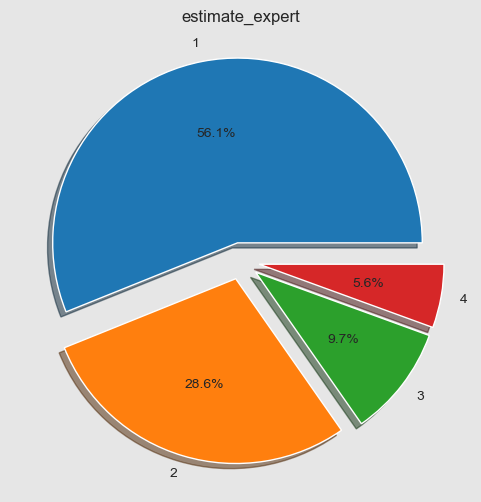

In [12]:
estimate_expert =  expert['e1'].value_counts().values + \
                   expert['e2'].value_counts().values + \
                   expert['e3'].value_counts().values

plt.figure(figsize=(6, 6))

plt.pie(x=estimate_expert, explode=np.ones(estimate_expert.shape[0])*0.1, shadow=True, 
        labels=['1', '2', '3', '4'], autopct='%1.1f%%')
plt.title('estimate_expert')

plt.show()

### Исследуем краудсорсинговые оценки

In [13]:
print('Число оценок краудсорсинга:', crowd.shape[0], '\n')
print('Топ 5 самых частых картинок:')
print(crowd['image'].value_counts()[:5], '\n')
print('Топ 5 самых редких картинок:')
print(crowd['image'].value_counts()[-5:], '\n')
print('Топ 5 самых частых запросов:')
print(crowd['query_id'].value_counts()[:5], '\n')
print('Топ 5 самых редких запросов:')
print(crowd['query_id'].value_counts()[-5:])

Число оценок краудсорсинга: 47830 

Топ 5 самых частых картинок:
image
1572532018_64c030c974.jpg    120
3250695024_93e8ab7305.jpg    110
1446053356_a924b4893f.jpg    100
505929313_7668f021ab.jpg     100
3359551687_68f2f0212a.jpg    100
Name: count, dtype: int64 

Топ 5 самых редких картинок:
image
2295750198_6d152d7ceb.jpg    10
3578841731_f775cab089.jpg    10
363617160_6cb0c723be.jpg     10
3449114979_6cdc3e8da8.jpg    10
3567061016_62768dcce1.jpg    10
Name: count, dtype: int64 

Топ 5 самых частых запросов:
query_id
249394748_2e4acfbbb5.jpg#2     169
820169182_f5e78d7d19.jpg#2     150
500446858_125702b296.jpg#2     149
2869491449_1041485a6b.jpg#2    143
327415627_6313d32a64.jpg#2     139
Name: count, dtype: int64 

Топ 5 самых редких запросов:
query_id
3191135894_2b4bdabb6d.jpg#2    9
3584561689_b6eb24dd70.jpg#2    7
3042380610_c5ea61eef8.jpg#2    7
1547883892_e29b3db42e.jpg#2    7
3197981073_3156963446.jpg#2    6
Name: count, dtype: int64


Выведем среднее значение оценок краудсорсинга

In [14]:
print('средняя оценка краудсорсинга', crowd['ratio'].mean())
print('Распределение числа согласных оценщиков')
print(crowd['respond'].value_counts(), '\n')
print('Распределение числа не согласных оценщиков')
print(crowd['mismatch'].value_counts(), '\n')

средняя оценка краудсорсинга 0.06878562966060352
Распределение числа согласных оценщиков
respond
0    41970
1     3119
2     1394
3     1328
4       14
5        5
Name: count, dtype: int64 

Распределение числа не согласных оценщиков
mismatch
3    41219
2     3034
1     1371
0     1323
4      665
5      176
6       42
Name: count, dtype: int64 



Построим диаграмму распределения оценок краудсорсинга

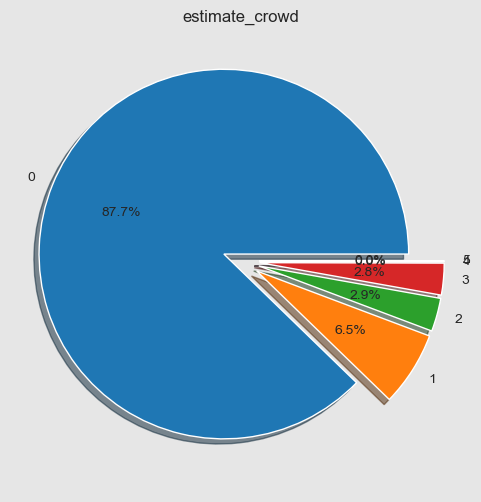

In [15]:
plt.figure(figsize=(6, 6))

freq = crowd['respond'].value_counts()
plt.pie(x=freq.values, explode=np.ones(freq.shape[0])*0.1, shadow=True, 
        labels=freq.index, autopct='%1.1f%%')
plt.title('estimate_crowd')

plt.show()

## Выгрузка картинок

Напишем класс датасета для визуализации картинок, преобразования изображений и запросов в вектора.

In [16]:
class CustomDataset(Dataset):
    """
    Датасет 
    """
    def __init__(self, data_file, mode):
        super().__init__()

        self.mode = mode

        if self.mode == 'transform_image':
            self.names = data_file['image'].values
            self.path_files = data_file['path_image'].values

        elif self.mode == 'transform_query':
            self.names = data_file['query_image'].values
            self.query_id = data_file['query_id'].values
            self.tokens = data_file['tokens'].values
            self.attention_mask = data_file['attention_mask'].values

        elif self.mode == 'display':
            self.names = data_file['image'].values
            self.path_files = data_file['path_image'].values
            self.query_text = data_file['query_text'].values

        else:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.names)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image 
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        if self.mode == 'transform_image':
            x = self.load_sample(self.path_files[index])
            x = self._prepare_sample(x)
            x = transform(x)
            name = self.names[index]
            return x, name

        elif self.mode == 'transform_query':
            tokens = self.tokens[index]
            attention_mask = self.attention_mask[index]
            query_id = self.query_id[index]
            return tokens, attention_mask, query_id
        
        elif self.mode == 'display':
            x = self.load_sample(self.path_files[index])
            x = self._prepare_sample(x)
            x = transform(x)
            query = self.query_text[index]
            return x, query

Функция отрисовки картинок

In [17]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Создадим в датасете отдельную колонку с путями к каждой картинке для удобства вывода.

In [18]:
train_dataset['path_image'] = train_dataset['image']. \
                              apply(lambda row: Path(os.path.join(DATA_PATH_LOCAL, 'train_images/') + row))

Отрисуем случайные картинки из датасета с соответствующими им запросами

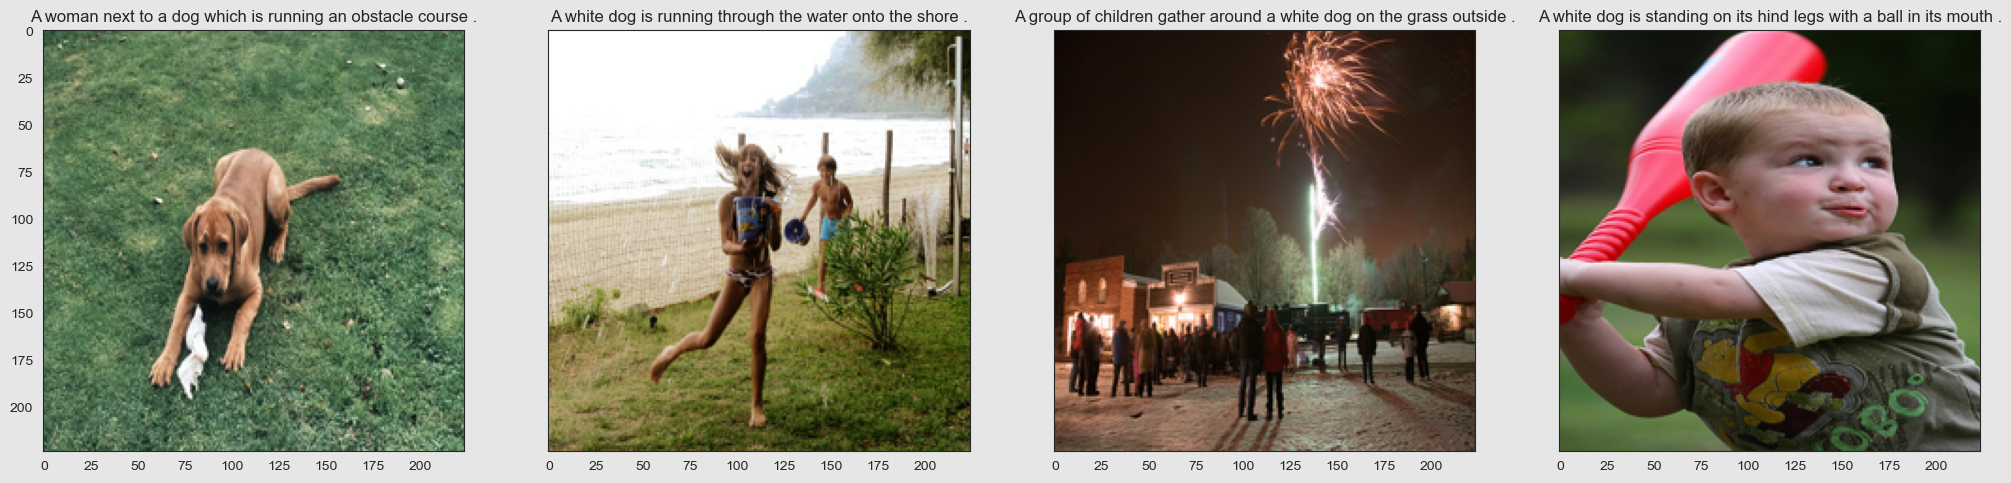

In [19]:
image_query_data = CustomDataset(train_dataset, mode='display')

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(25, 12), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0, 5272))
    image, query = image_query_data[random_characters]
    
    imshow(image.data.cpu(),
           title=query, 
           plt_ax=fig_x)

Вывод по EDA:

- В тренировочном наборе данных имеем 5822 уникальных сочетаний картинок и запросов, 1000 уникальных картинок и 977 уникальных запросов;  
- В тестовом наборе данных имеем 500 уникальных сочетаний запросов и картинок, 500 уникальных запросов и 100 уникальных картинок, каждая картинка имеет 5 разных запросов;  
- Экспертные оценки полностью соответствуют обучающей выборке, всего оценок 5822;  
- Каждое сочетание картинка - запрос в обучающей выборке имеет 3 экспертные оценки;  
- Всего есть четыре варинта экспертных оценок: 1 - изображение полностью не соответствует запросу, 2 - изображение частично соответствует запросу, 3 - изображение частично не соответствует запросу, 4 - изображение полностью соответствует запросу;
- В экспертных оценках каждая картинка имеет как минимум две оценки соответствия;  
- Совокупная доля оценок 1, 2 составляет 85%, 3, 4 - 15%;
- Число оценок краудсорсинга составляет 47830;  
- Краудсорсинговые оценки обладают большей категоричностью, чем экспертные, и имеют два варинта соответствия: соответствует полностью или не соответствует вообще.  
- Также в краудсорсинговых оценках есть информация сколько людей посчитала, что изображение соответствует запросу, и сколько людей считает, что не соответствует;  
- Более чем в 87% случаев число людей, считающих, что изображение соответствует запросу, равно нулю.  
- Из визуального анализа картинок и запросов к ним из обучающего датасета можно сказать, что они крайне отличаются друг от друга в большинстве случаев, что скорее всего сделано для того, чтобы модель училась выявлять сложные зависимости между запросом и изображением.

Вывод по выбору таргета:  

Для обучения моделей в качестве таргета выберем экспертные оценки, поскольку они точнее описывают соответствие изображения запросу, что позволит модели точнее выучить зависимость и быть болеее гибкой; К тому же экспертные оценки полностью соответствуют сочетаниям из обучающей выборки, что позволит без проблем объединить эти два датасета.
В качестве метода агрегации экспертных оценок выберем метод большинства и отшкалируем оценку в диапозон от 0 до 1 с помощью линейного преобразования (х-1)/3. Сочетания изображений с запросов, в которых все эксперты дали разные оценки, не будем учитывать при обучении.   

Вывод по преобразованию изображений и запросов в вектора:
- Изображения будем преобразовывать с помощью backbone resnet18 предъобученной на датасете ImageNet;
- Вектора запросов получим с помощью трансформера Bert.

## Агрегация экспертных оценок и их нормализация

Для исследования будем использовать только оценки экспертов.  
Агрегируем их методом большинства

In [20]:
def aggregate_score(row):
    values, counts = np.unique(row.values, return_counts=True)

    if counts.max() == 1:
        return 0
    
    else:
        return values[counts.argmax()]
    
expert['agg_est'] = expert[['e1', 'e2', 'e3']].apply(aggregate_score, axis=1)

display(expert.query('agg_est == 0'))
bad_estimate_pairs = expert.query('agg_est == 0')[['image', 'query_id']]
expert_good_estimate = expert[expert['agg_est'] != 0]
expert.sample(5)

image                     query_id  e1  e2  e3  \
17    1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2   1   2   3   
40    1119015538_e8e796281e.jpg  2534502836_7a75305655.jpg#2   2   3   4   
47    1122944218_8eb3607403.jpg  3325497914_f9014d615b.jpg#2   2   3   4   
168   1287475186_2dee85f1a5.jpg  2918769188_565dd48060.jpg#2   1   2   3   
199   1329832826_432538d331.jpg  1536774449_e16b1b6382.jpg#2   1   2   3   
...                         ...                          ...  ..  ..  ..   
5656   732468337_a37075225e.jpg  3516825206_5750824874.jpg#2   1   2   3   
5708   766099402_cdda6964f0.jpg  2971431335_e192613db4.jpg#2   1   2   3   
5753   880220939_0ef1c37f1f.jpg  1389264266_8170bc1c54.jpg#2   1   2   3   
5757   880220939_0ef1c37f1f.jpg   311146855_0b65fdb169.jpg#2   1   2   3   
5809   979383193_0a542a059d.jpg  3108197858_441ff38565.jpg#2   1   2   3   

      agg_est  
17          0  
40          0  
47          0  
168         0  
199         0  
...       ...  
5656        0  
5708        0  
5753        0  
5757        0  
5809        0  

[126 rows x 6 columns]

image                     query_id  e1  e2  e3  \
3368  3214885227_2be09e7cfb.jpg   136886677_6026c622eb.jpg#2   3   3   3   
2116  2731171552_4a808c7d5a.jpg  1267711451_e2a754b4f8.jpg#2   1   1   1   
673   2049051050_20359a434a.jpg  3047264346_e24601bfbf.jpg#2   1   1   1   
3865  3358682439_be4b83544c.jpg  1402640441_81978e32a9.jpg#2   1   1   1   
432   1509786421_f03158adfc.jpg  3218480482_66af7587c8.jpg#2   1   1   1   

      agg_est  
3368        3  
2116        1  
673         1  
3865        1  
432         1

Отшкалируем оценки экспертов в диапозон от 0 до 1

In [21]:
expert_good_estimate['norm_agg_est'] = (expert_good_estimate['agg_est'] - 1) / 3

display(expert_good_estimate.sample(10))

print(expert_good_estimate['norm_agg_est'].min(), expert_good_estimate['norm_agg_est'].max())

display(expert_good_estimate['norm_agg_est'].value_counts())

image                     query_id  e1  e2  e3  \
5661   745880539_cd3f948837.jpg   745880539_cd3f948837.jpg#2   4   4   4   
3457  3224227640_31865b3651.jpg  1659358141_0433c9bf99.jpg#2   2   2   2   
4082  3432550415_e7b77232de.jpg   300577375_26cc2773a1.jpg#2   1   1   1   
4871  3670907052_c827593564.jpg  1408958345_68eea9a4e4.jpg#2   1   1   1   
4679  3591462960_86045906bd.jpg  3591462960_86045906bd.jpg#2   4   4   4   
2206  2797149878_bb8e27ecf9.jpg  2994179598_a45c2732b5.jpg#2   1   1   1   
2873  3058439373_9276a4702a.jpg  3245912109_fdeef6b456.jpg#2   4   4   4   
3014  3108732084_565b423162.jpg   280706862_14c30d734a.jpg#2   1   1   1   
62     114051287_dd85625a04.jpg  3281078518_630a7a7f4f.jpg#2   1   1   1   
1782  2581066814_179d28f306.jpg   416960865_048fd3f294.jpg#2   1   1   1   

      agg_est  norm_agg_est  
5661        4      1.000000  
3457        2      0.333333  
4082        1      0.000000  
4871        1      0.000000  
4679        4      1.000000  
2206        1      0.000000  
2873        4      1.000000  
3014        1      0.000000  
62          1      0.000000  
1782        1      0.000000

0.0 1.0


norm_agg_est
0.000000    3327
0.333333    1566
0.666667     492
1.000000     311
Name: count, dtype: int64

Объединим тренировочный датасет с датасетом экспертных оценок по двум колонкам image и query_id.  

In [22]:
train_dataset_with_agg_est = pd.merge(train_dataset, 
                                      expert_good_estimate, 
                                      on=['image', 'query_id'], 
                                      how='inner')

train_dataset_with_agg_est = train_dataset_with_agg_est.reset_index(drop=True)

display(train_dataset_with_agg_est.sample(5))
display(train_dataset_with_agg_est.shape)
display(train_dataset_with_agg_est.query('agg_est == 0') )

image                     query_id  \
2293  2854959952_3991a385ab.jpg  1626754053_81126b67b6.jpg#2   
2511  2204550058_2707d92338.jpg  3718964174_cb2dc1615e.jpg#2   
854   3245070961_8977fdd548.jpg  2218609886_892dcd6915.jpg#2   
3988  3119076670_64b5340530.jpg  3578841731_f775cab089.jpg#2   
382   1131800850_89c7ffd477.jpg  2345984157_724823b1e4.jpg#2   

                                             query_text  \
2293  A black and white dog prepares to catch a Fris...   
2511  A woman is wearing a blue headscarf and a blue...   
854   A man wearing a dark blue hat sits on the grou...   
3988  a red and white race car racing on a dirt race...   
382                     A brown dog shaking off water .   

                                             path_image  e1  e2  e3  agg_est  \
2293  ..\data\data_image_search\train_images\2854959...   3   3   3        3   
2511  ..\data\data_image_search\train_images\2204550...   2   2   2        2   
854   ..\data\data_image_search\train_images\3245070...   1   1   1        1   
3988  ..\data\data_image_search\train_images\3119076...   1   1   1        1   
382   ..\data\data_image_search\train_images\1131800...   3   4   4        4   

      norm_agg_est  
2293      0.666667  
2511      0.333333  
854       0.000000  
3988      0.000000  
382       1.000000

(5696, 9)

Empty DataFrame
Columns: [image, query_id, query_text, path_image, e1, e2, e3, agg_est, norm_agg_est]
Index: []

### Вывод по разделу:  

Вывод по EDA:

- В тренировочном наборе данных имеем 5822 уникальных сочетаний картинок и запросов, 1000 уникальных картинов и 977 уникальных запросов;  
- В тестовом наборе данных имеем 500 уникальных сочетаний запросов и картинок, 500 уникальных запросов и 100 уникальных картинок, каждая картинка имеет 5 разных запросов;  
- Экспертные оценки полностью соответствуют обучающей выборке, всего оценок 5822;  
- Каждое сочетание картинка - запрос в обучающей выборке имеет 3 экспертные оценки;  
- Всего есть четыре варинта экспертных оценок: 1 - изображение полностью не соответствует запросу, 2 - изображение частично соответствует запросу, 3 - изображение частично не соответствует запросу, 4 - изображение полностью соответствует запросу;
- В экспертных оценках каждая картинка имеет как минимум две оценки соответствия;  
- Совокупная доля оценок 1, 2 составляет 85%, 3, 4 - 15%;
- Число оценок краудсорсинга составляет 47830;  
- Краудсорсинговые оценки обладают большей категоричностью, чем экспертные, и имеют два варинта соответствия: соответствует полностью или не соответствует вообще.  
- Также в краудсорсинговых оценках есть информация сколько людей посчитала, что изображение соответствует запросу, и сколько людей считает, что не соответствует;  
- Более чем в 87% случаев число людей, считающих, что изображение соответствет запросу, равно нулю.  
- Из визуального анализа картинок и запросов к ним из обучающего датасета можно сказать, что они крайне отличаются друг от друга в большинстве случаев, что скорее всего сделано для того, чтобы модель училась выявлять сложные зависимости между запросом и изображением.

Вывод по выбору таргета:  

Для обучения моделей в качестве таргета были выбраны экспертные оценки, поскольку они точнее описывают соответствие изображения запросу, что позволит модели точнее выучить зависимость и быть болеее гибкой.

Вывод по преобразованию экспертных оценок:

Каждые три экспертные оценки для соответствующего сочетания картинка - запрос были агрегированы методом большинства и отшкалированы с помощью линейного преобразования (х-1)/3.  
Тренировочный набор данных был объединен с набор экспертных оценок по двум колонкам image и query_id.  

Вывод по дальнейшему преобразованию изображений и запросов в вектора:  

- Изображения будем преобразовывать с помощью backbone resnet18 предъобученной на датасете ImageNet;
- Вектора запросов получим с помощью трансформера Bert.

## 3. Фильтрация данных

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Мы хотим строго соблюдать возможные ограничения, поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок будем показывать дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Также удалим из тренировочной выборки все изображения, которые попадают под ограничения.

Выпишем слова связанные с детьми

Слова связанные с детьми:  

boyhood,   
childhood,   
childish,   
childlike,   
daughter,   
junior,   
kid,   
minor,   
nursery,   
son,   
child,   
children,   
baby,   
infancy,  
infant,  
neonate,  
newborn,  
toddler,  
adolescent,   
teener  

In [23]:
child_words = {'boyhood', 'childhood', 'childish', 'childlike', 'daughter', 
               'junior', 'kid', 'minor', 'nursery', 'son', 'child', 'children', 
               'baby', 'infancy', 'infant', 'neonate',
               'newborn', 'toddler', 'adolescent', 'teener'}

Для выписанных слов найдем возможные синонимы и дополним список

In [24]:
synonyms = [] 
antonyms = [] 

for word in child_words:
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name()) 
            if l.antonyms(): 
                antonyms.append(l.antonyms()[0].name()) 
      
for word in set(synonyms):
    print(word)

childish
cosset
baby's_room
tot
Word
spoil
minor
banter
Jr
youngster
nipper
pamper
newborn
newborn_baby
round-eyed
wide-eyed
nonaged
shaver
cocker
new-sprung
fry
babe
sister
Junior
bambino
featherbed
Kid
teenager
teenaged
childly
jejune
next-to-last
nursery
small-scale
Logos
venial
jolly
Thomas_Kyd
glasshouse
newborn_infant
boy
stripling
infant
boyhood
chaff
tike
infantile
girl
pull_the_leg_of
toddler
adolescent
modest
third-year
childhood
neonate
josh
son
Jnr
indulge
kid
early_childhood
tyke
simple
juvenile
infancy
tiddler
child
coddle
underage
nestling
Son
baby
small
Kyd
pocket-sized
yearling
daughter
mollycoddle
puerility
dewy-eyed
junior
pocket-size
teenage
kidskin
teen
childlike
Thomas_Kid
babyhood
puerile
small_fry
greenhouse


In [25]:
child_words = {'babyhood', 'yearling', 'puerility', 'newborn', 'infant',
              'underage', 'junior', 'toddler', 'kid', 'teenage', 'teenager',  
              'child', 'childhood', 'juvenile', 'baby', 'adolescent',
              'kidskin', 'neonate', 'babe', 'daughter', 'junior', 'tot', 'youngster',  
              'boyhood', 'teenaged', 'stripling', 'son', 'teen', 'childish', 'sister',
              'infancy', 'puerile'}

Лемматизируем тексты запросов

In [26]:
m = WordNetLemmatizer()

def cleaner_text(row):
    text = row.lower()
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return " ".join(text.split())

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemma(row):
    clean_row = cleaner_text(row)
    tokens = word_tokenize(clean_row)
    text = " ".join([m.lemmatize(word, get_wordnet_pos(word)) for word in tokens])
    return text

In [27]:
train_dataset_with_agg_est['query_lemm_text'] = train_dataset_with_agg_est['query_text'].apply(lemma)

train_dataset_with_agg_est[['query_text', 'query_lemm_text']].sample(10).values

array([['girl posing on tree', 'girl pose on tree'],
       ['Two men walk through a city with words on the street .',
        'two men walk through a city with word on the street'],
       ['A motocross bike is being ridden along a woodland path .',
        'a motocross bike be be ridden along a woodland path'],
       ['a dog on the beach .', 'a dog on the beach'],
       ['Snowboarders sitting in the snow while skiers take the hill .',
        'snowboarder sit in the snow while skier take the hill'],
       ['Two dogs moving through water close to the shore .',
        'two dog move through water close to the shore'],
       ['A woman in a red shirt holding a cellphone .',
        'a woman in a red shirt hold a cellphone'],
       ['A skateboarder is jumping through the air in front of a graffiti covered wall .',
        'a skateboarder be jumping through the air in front of a graffiti cover wall'],
       ['A person walks along the beach and leaves footprints in the sand .',
      

Удалим из датасета запросы и картинки связанные с детьми

In [28]:
# Получаем срез датасета в строках которого есть запросы про детей
bad_query = train_dataset_with_agg_est[[not child_words.isdisjoint(set(row.split(" "))) 
                                        for row in train_dataset_with_agg_est['query_lemm_text']]]
print('Число запрос, связанных с детьми:', len(bad_query['query_text']))
print('Число уникальных запросов, связанных с детьми:', bad_query['query_text'].nunique())

# Получаем имена картинок из идентификаторов запроса про детей
bad_image = [row[:-2] for row in bad_query['query_id'].unique()]
print('Число уникальных картинок на которых есть дети, соглано описанию:', len(bad_image))

print('Размер входного датасета:', train_dataset_with_agg_est.shape)

# Получим новый датасет без запросов про детей
final_train_dataset = train_dataset_with_agg_est[[child_words.isdisjoint(set(row.split(" "))) 
                                                  for row in train_dataset_with_agg_est['query_lemm_text']]]
print('Размер датасета после удаления запросов про детей:', final_train_dataset.shape)

# Удалим картинки, на которых изображены дети
final_train_dataset = final_train_dataset[final_train_dataset['image'].apply(
    lambda row: row not in bad_image)]
print('Размер датасета после удаления картинок с детьми:', final_train_dataset.shape)

# Переназначим новые индексы
final_train_dataset = final_train_dataset.reset_index(drop=True)

print('Образцы "плохих" запросов:')
display(bad_query['query_text'].unique())

Число запрос, связанных с детьми: 534
Число уникальных запросов, связанных с детьми: 98
Число уникальных картинок на которых есть дети, соглано описанию: 98
Размер входного датасета: (5696, 10)
Размер датасета после удаления запросов про детей: (5162, 10)
Размер датасета после удаления картинок с детьми: (4681, 10)
Образцы "плохих" запросов:


array(['A young child is wearing blue goggles and sitting in a float in a pool .',
       'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .',
       'The kid is on a float in the snow .',
       'A child is preparing to slide down a piece of playground equipment .',
       'The baby in suspenders sits by a toy .',
       'Two little children and one is playing with a slinky .',
       'A child jumping on a tennis court .',
       'A child sleds over a mound of snow as others watch him .',
       'Child sitting at a backyard picnic table .',
       'Group of children in blue uniforms sitting on steps .',
       'Two woman and a child look at each other while a night party scene goes on behind them .',
       'A young child with a dirty shirt is standing on a playground',
       'A happy child dangling from playground equipment smiles at the camera .',
       'A young child is riding a purple bike .',
       'A kid in 

Получим датасет с изображениями, которые могут попасть под ограничения и которые мы удалили из обучающей выборки.

In [29]:
# Получим датасет с уникальными запросами про детей и соответствующими им картинками 
bad_image_dataset = pd.DataFrame(bad_query['query_id'].unique(), columns=['query_id'])
bad_image_dataset['image'] = [row[:-2] for row in bad_image_dataset['query_id']]
bad_image_dataset['path_image'] = [train_dataset_with_agg_est.query('image == @i')['path_image'].unique()[0]
                                   for i in bad_image_dataset['image']]
bad_image_dataset['query_text'] = [train_dataset_with_agg_est.query('query_id == @i')['query_text'].unique()[0]
                                   for i in bad_image_dataset['query_id']]
bad_image_dataset['agg_est'] = np.zeros((len(bad_image_dataset)))

bad_image_dataset_display = CustomDataset(bad_image_dataset, 'display')

# отрисуем все плохие картинки и соответствующие им запросы
#fig, ax = plt.subplots(nrows=25, ncols=4, figsize=(25, 150),
#                       sharey=True, sharex=True)
#i = -1
#
#for fig_x in ax.flatten():
#
#    i += 1
#
#    if i == 98:
#        break
#    
#    image, query = bad_image_dataset_display[i]
#    query_n_number = query + '\n' + 'number:' + str(i)
#    
#    imshow(image.data.cpu(),
#           title=query_n_number, 
#           plt_ax=fig_x)

Подготовим датафреймы с уникальными запросами и картинками для простоты из векторизации

In [30]:
unique_query = pd.DataFrame(final_train_dataset['query_id'].unique(), columns=['query_id'])
unique_query['query_text'] = [final_train_dataset[final_train_dataset['query_id'] == i]['query_text'].unique()[0]
                              for i in unique_query['query_id']]
unique_query['query_lemm_text'] = [final_train_dataset[final_train_dataset['query_id'] == i]['query_lemm_text'].unique()[0]
                              for i in unique_query['query_id']]
unique_query['query_image'] = [i[:-2] for i in unique_query['query_id']]

unique_image = pd.DataFrame(final_train_dataset['image'].unique(), columns=['image'])
unique_image['path_image'] = [final_train_dataset[final_train_dataset['image'] == i]['path_image'].unique()[0]
                              for i in unique_image['image']]

display(unique_image.shape)
display(unique_image)
display(unique_query.shape)
display(unique_query)

(902, 2)

image  \
0    1056338697_4f7d7ce270.jpg   
1    1167669558_87a8a467d6.jpg   
2    2648165716_02e2e74fd6.jpg   
3    2718495608_d8533e3ac5.jpg   
4    3244747165_17028936e0.jpg   
..                         ...   
897  3741827382_71e93298d0.jpg   
898  3518126579_e70e0cbb2b.jpg   
899  3544793763_b38546a5e8.jpg   
900  2490768374_45d94fc658.jpg   
901  2533424347_cf2f84872b.jpg   

                                            path_image  
0    ..\data\data_image_search\train_images\1056338...  
1    ..\data\data_image_search\train_images\1167669...  
2    ..\data\data_image_search\train_images\2648165...  
3    ..\data\data_image_search\train_images\2718495...  
4    ..\data\data_image_search\train_images\3244747...  
..                                                 ...  
897  ..\data\data_image_search\train_images\3741827...  
898  ..\data\data_image_search\train_images\3518126...  
899  ..\data\data_image_search\train_images\3544793...  
900  ..\data\data_image_search\train_images\2490768...  
901  ..\data\data_image_search\train_images\2533424...  

[902 rows x 2 columns]

(876, 4)

query_id  \
0    2718495608_d8533e3ac5.jpg#2   
1    3181701312_70a379ab6e.jpg#2   
2    3207358897_bfa61fa3c6.jpg#2   
3    3286822339_5535af6b93.jpg#2   
4    3360930596_1e75164ce6.jpg#2   
..                           ...   
871  2061144717_5b3a1864f0.jpg#2   
872  2196107384_361d73a170.jpg#2   
873  2112921744_92bf706805.jpg#2   
874  3651971126_309e6a5e22.jpg#2   
875  2292406847_f366350600.jpg#2   

                                            query_text  \
0    A girl wearing a yellow shirt and sunglasses s...   
1      A man sleeps under a blanket on a city street .   
2    A woman plays with long red ribbons in an empt...   
3           Chinese market street in the winter time .   
4    A soccer ball is above the head of a man weari...   
..                                                 ...   
871         A man in an ampitheater talking to a boy .   
872          a old man walks down the uncrowded road .   
873       A dog stands on the side of a grassy cliff .   
874                       A blurry photo of two dogs .   
875                        A man rows his boat below .   

                                       query_lemm_text  \
0        a girl wear a yellow shirt and sunglass smile   
1         a man sleep under a blanket on a city street   
2    a woman play with long red ribbon in an empty ...   
3             chinese market street in the winter time   
4    a soccer ball be above the head of a man wear ...   
..                                                 ...   
871              a man in an ampitheater talk to a boy   
872             a old man walk down the uncrowded road   
873          a dog stand on the side of a grassy cliff   
874                          a blurry photo of two dog   
875                           a man row his boat below   

                   query_image  
0    2718495608_d8533e3ac5.jpg  
1    3181701312_70a379ab6e.jpg  
2    3207358897_bfa61fa3c6.jpg  
3    3286822339_5535af6b93.jpg  
4    3360930596_1e75164ce6.jpg  
..                         ...  
871  2061144717_5b3a1864f0.jpg  
872  2196107384_361d73a170.jpg  
873  2112921744_92bf706805.jpg  
874  3651971126_309e6a5e22.jpg  
875  2292406847_f366350600.jpg  

[876 rows x 4 columns]

Вывод по разделу:  
Из обучающего датасета были удалены все запросы связанные с детьми и все изображения, на которых согласно соответствующих им запросов были изображены дети. Всего было удаленно 98 уникальных запросов и 98 соответствующих им картинок.

## 4. Векторизация изображений

Перейдём к векторизации изображений.

Для векторизации изображений будем использовать архитектуру ResNet-18 предъобученную на датасете ImageNet, из которой удалим полносвязные слои, отвечающие за конечные предсказания.

Загрузим предобученную сеть ResNet-18

In [31]:
try:
    resnet = models.resnet18()
    resnet.load_state_dict(torch.load('resnet18_weights.pth'))

except:
    resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

In [32]:
print(list(resnet.children())) 

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Удалим последний слой и добавим слой Flatten

In [33]:
modules = list(resnet.children())[:-1] + [nn.Flatten()]
resnet = nn.Sequential(*modules) 

resnet.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Получим вектора картинок

In [34]:
transform_dataset = CustomDataset(unique_image, 'transform_image') 

In [35]:
def transorm_image(model, dataset):
    
    embending_image = []
    
    model.eval()
    model.to(DEVICE)

    dataloader = DataLoader(dataset, batch_size=1)

    for input, label in dataloader:
        input = input.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            output = model(input)

        output = list(output.cpu().numpy()[0])
        embending_image.append(output)

    model.to('cpu')
    embending_image = np.array(embending_image)

    return embending_image

In [37]:
embending_image = transorm_image(resnet, transform_dataset)

In [38]:
embending_image.shape

(902, 512)

Вывод по разделу:    
Изображения были векторизированы с помощью сети ResNet18.  
Итоговая размерность веткора изображения составила 512 элементов.

## 5. Векторизация текстов


In [39]:
random.seed(RANDOM_STATE)

torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

Для векторизации запросов будем использовать трансформер Bert

In [40]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

Получим токены и маску внимания для каждого запроса

In [41]:
def transform_query(tokenizer, query):
    encoding_text = tokenizer.batch_encode_plus(query,
                                                padding=True,
                                                truncation=True,
                                                return_tensors='pt',
                                                add_special_tokens=True)
    
    encoding_query = pd.DataFrame(columns=[['tokens', 'attention_mask']])

    for i in range(len(query)):
        encoding_query.loc[len(encoding_query), :] = [encoding_text['input_ids'][i].numpy(),
                                                      encoding_text['attention_mask'][i].numpy()]
 
    return encoding_query


In [42]:
encoding_query = transform_query(bert_tokenizer, 
                                 unique_query['query_lemm_text'].values)

unique_query.loc[:, ['tokens', 'attention_mask']] = encoding_query.values

In [43]:
unique_query.head()

query_id  \
0  2718495608_d8533e3ac5.jpg#2   
1  3181701312_70a379ab6e.jpg#2   
2  3207358897_bfa61fa3c6.jpg#2   
3  3286822339_5535af6b93.jpg#2   
4  3360930596_1e75164ce6.jpg#2   

                                          query_text  \
0  A girl wearing a yellow shirt and sunglasses s...   
1    A man sleeps under a blanket on a city street .   
2  A woman plays with long red ribbons in an empt...   
3         Chinese market street in the winter time .   
4  A soccer ball is above the head of a man weari...   

                                     query_lemm_text  \
0      a girl wear a yellow shirt and sunglass smile   
1       a man sleep under a blanket on a city street   
2  a woman play with long red ribbon in an empty ...   
3           chinese market street in the winter time   
4  a soccer ball be above the head of a man wear ...   

                 query_image  \
0  2718495608_d8533e3ac5.jpg   
1  3181701312_70a379ab6e.jpg   
2  3207358897_bfa61fa3c6.jpg   
3  3286822339_5535af6b93.jpg   
4  3360930596_1e75164ce6.jpg   

                                              tokens  \
0  [101, 1037, 2611, 4929, 1037, 3756, 3797, 1998...   
1  [101, 1037, 2158, 3637, 2104, 1037, 8768, 2006...   
2  [101, 1037, 2450, 2377, 2007, 2146, 2417, 1055...   
3  [101, 2822, 3006, 2395, 1999, 1996, 3467, 2051...   
4  [101, 1037, 4715, 3608, 2022, 2682, 1996, 2132...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

Получим вектора запросов

In [44]:
def get_embending_query(model, dataset, batch_size):

    model.eval()
    model.to(DEVICE)

    dataloader = DataLoader(dataset, batch_size=batch_size)

    embendings = []

    for token, mask, query_id in dataloader:
        token = torch.LongTensor(token)
        mask = torch.LongTensor(mask)
        token = token.to(DEVICE)
        mask = mask.to(DEVICE)
        
        #embendings = []
        with torch.set_grad_enabled(False):
            output = model(token, attention_mask = mask)

        embendings.append(output[0][:,0,:].cpu().numpy())
        
    embendings = np.concatenate(embendings) 
        
    model.to('cpu')
    
    return embendings

In [45]:
query_dataset = CustomDataset(unique_query, mode='transform_query')
embending_query = get_embending_query(bert_model, query_dataset, batch_size=16)

In [46]:
embending_query.shape

(876, 768)

Вектора запросов получены. Размер каждого вектора составляет 768 значений. Осталось их объединить с векторами изображений.

## 6. Объединение векторов

Объедим вектора картинок и запросов

In [47]:
image_query_embendings = np.zeros([final_train_dataset.shape[0], embending_image.shape[1] + embending_query.shape[1]])

for i in range(len(final_train_dataset)):
    i_image = final_train_dataset.loc[i, 'image']
    i_query_id = final_train_dataset.loc[i, 'query_id']
    vector_image = embending_image[unique_image.query('image == @i_image').index[0]]
    vector_query = embending_query[unique_query.query('query_id == @i_query_id').index[0]]
    image_query_embendings[i] = np.concatenate((vector_image, vector_query))

In [48]:
image_query_embendings = image_query_embendings.astype('float32')

In [49]:
image_query_embendings.shape

(4681, 1280)

Вывод по разделу:  
Ветора изображений и запросов объединены.  
Итоговая размерность признакового описания составляет 1280 значений.

## 7. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и валидационную выборки. Простое случайное разбиение не подходит: нам нужно исключить попадание изображения и в обучающую, и в валидационную выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```


Исследовать будем два типа моделей:  
- Линейная регрессия
- Полносвязанная нейронная сеть.  

Качество моделей будем измерять по метрике RMSE.  

Выбор метрики RMSE боснован следующими критериями:  

Метрика MSE  применяется в случаях, когда требуется 
подчеркнуть большие ошибки и выбрать модель, 
которая дает меньше именно больших ошибок.  
В нашем случае "небольшие" 
ошибки моделей не так значительны, гораздо важнее, когда модель координально
ошибется в соответствии изображения запросу.  
Сравнение моделей по метрике RMSE даст такой же результат, что и по метрике
MSE.  
К тому же метрику RMSE в данном случае будет проще интерпритировать
поскольку она будет лежать в том же диапазоне, что и таргет.

Разделим датасет на тренировочный и валидационный 

In [50]:
df = final_train_dataset[['image', 'query_id', 'query_text', 'agg_est',
                          'norm_agg_est', 'path_image']]

gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)

train_indices, valid_indices = next(gss.split(X = df.drop(columns=['norm_agg_est']), 
                                              y = df['norm_agg_est'], 
                                              groups = df['image']))

train_df, valid_df = df.loc[train_indices], df.loc[valid_indices]
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape, valid_df.shape)
print(len(set(train_df['image'].values)), len(set(valid_df['image'].values)))
print(len(set(train_df['image'].values)) + len(set(valid_df['image'].values)))
print(set(train_df['image'].values).isdisjoint(set(valid_df['image'].values)))

(3729, 6) (952, 6)
721 181
902
True


Получим признаковое описание и целевую переменную

In [51]:
X_train = image_query_embendings[train_indices]
y_train = train_df['norm_agg_est'].values.astype('float32')
X_valid = image_query_embendings[valid_indices]
y_valid = valid_df['norm_agg_est'].values.astype('float32')

Отмасштабируем данные перед обучением. Будем использовать два метода библиотеки sklearn Normalizer и StandardScaler.  
По результатм обучения выберем на каком из них модели обучились лучше.

In [52]:
norm_scaler = Normalizer()
std_scaler = StandardScaler()

norm_scaler.fit(X_train)
std_scaler.fit(X_train)

X_train_norm = norm_scaler.transform(X_train)
X_valid_norm = norm_scaler.transform(X_valid)

X_train_std = std_scaler.transform(X_train)
X_valid_std = std_scaler.transform(X_valid)

Используем константную модель для сравнения с ней других моделей

In [53]:
dummy_regr = DummyRegressor()

dummy_regr.fit(X_train, y_train)
predict = dummy_regr.predict(X_valid)

rmse = mean_squared_error(y_valid, predict, squared=False)
mae = mean_absolute_error(y_valid, predict)
r2 = r2_score(y_valid, predict)

print(f'rmse = {rmse}')
print(f'mae = {mae}')
print(f'r2_score = {r2}')

rmse = 0.2853524684906006
mae = 0.2399439811706543
r2_score = -0.00684547981863437


Значние метрики RMSE на валидационной выборке константная модель показала 0.285.  
Нам как минимум необходимо его превысить, чтобы обосновать возможность создания необходимой модели.

Обучим модель линейной регрессии на не масштабированных данных и на масштабированных

Обучение на немасштабированных данных


In [54]:
LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

predict = LR_model.predict(X_valid)

rmse = mean_squared_error(y_valid, predict, squared=False)
mae = mean_absolute_error(y_valid, predict)
r2 = r2_score(y_valid, predict)

print(f'rmse = {rmse}')
print(f'mae = {mae}')
print(f'r2_score = {r2}')

rmse = 0.4092305898666382
mae = 0.32201963663101196
r2_score = -1.070788266600089


Обучение на данных машстабированных с помощью Normalizer

In [55]:
LR_model_norm = LinearRegression()

LR_model_norm.fit(X_train_norm, y_train)

predict_norm = LR_model_norm.predict(X_valid_norm)

rmse = mean_squared_error(y_valid, predict_norm, squared=False)
mae = mean_absolute_error(y_valid, predict_norm)
r2 = r2_score(y_valid, predict_norm)

print(f'rmse = {rmse}')
print(f'mae = {mae}')
print(f'r2_score = {r2}')

rmse = 0.4037664234638214
mae = 0.3196186125278473
r2_score = -1.0158583071820173


Обучение на данных машстабированных с помощью StandardScaler

In [56]:
LR_model_std = LinearRegression()

LR_model_std.fit(X_train_std, y_train)

predict_std = LR_model_std.predict(X_valid_std)

rmse = mean_squared_error(y_valid, predict_std, squared=False)
mae = mean_absolute_error(y_valid, predict_std)
r2 = r2_score(y_valid, predict_std)

print(f'rmse = {rmse}')
print(f'mae = {mae}')
print(f'r2_score = {r2}')

rmse = 0.409231960773468
mae = 0.3220193386077881
r2_score = -1.070802495409493


На валидационной выборке значение метрики RMSE принимает   
следующие значений:  
0.4092 на немасштабированных данных  
0.4037 на данных масштабированных с помощью Normalizer  
0.4092 на данных машстабированных с помощью StandardScaler  

Линейная регрессия не смогла превысить качество константной модели.

### Полносвязанная нейросеть

Описание рассматриваемых гиперпараметров.

В качестве Loss`a будем использовать MSE. Оптимизатор - Adam с learning rate = 0.001.

Исследовать будем следующие архитектуры:  
- 1024 -> 512 -> 1
- 512 -> 256 -> 1
- 256 -> 128 -> 1

Также рассмотрим следующие функции активации:
- ReLU,  
- ELU,  
- LeakyReLU. 

Исследуем влияние нормализации весов с помощью BatchNorm`a на результат обучения.  

Сравнивать модели будем по метрике RMSE.

Лучшую модель обучим на 2000 эпохах с применением шедулера с шагом в 500 эпох и gamma = 0.1.

Подготовим функции для обучения сети

Определим класс датасета для обучения и тестирования

In [30]:
class TVDataset(Dataset):
    def __init__(self, mode, X, y=None):
        super().__init__()
        self.mode = mode
        self.X = X
        if self.mode != 'test':
            self.y = y

        self.len_ = len(X)

    def __len__(self):
        return self.len_
    
    def __getitem__(self, index):
        X = self.X[index]
        if self.mode != 'test':
            y = self.y[index]
            return X, y
        else:
            return X

Функция обучения за одну эпоху

In [14]:
def fit_epoch(model, train_loader, Loss, optimizer):
    model.train(True)
    
    running_loss = 0.0
    processed_data = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = Loss(outputs.flatten(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_rmse = mean_squared_error(targets.cpu().detach().numpy(), 
                                    outputs.flatten().cpu().detach().numpy(), 
                                    squared=False)
    return train_loss, train_rmse

Функция валидации за одну эпоху

In [15]:
def eval_epoch(model, valid_loader, Loss):
    model.eval()

    running_loss = 0.0
    processed_size = 0

    for inputs, targets in valid_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = Loss(outputs.flatten(), targets)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_rmse = mean_squared_error(targets.cpu().detach().numpy(), 
                                  outputs.flatten().cpu().detach().numpy(), 
                                  squared=False)
    
    return val_loss, val_rmse

Функция полного обучения

In [16]:
def train(model, Loss, optimizer,
          train_loader, valid_loader, num_epochs, 
          scheduler=False, logs=False):
    
    model.to(DEVICE)

    best_model_wts = model.state_dict()
    best_rmse = 1000000
    best_epoch = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_rmse {t_rmse:0.4f} val_rmse {v_rmse:0.4f}"

    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:

        for epoch in range(num_epochs):

            train_loss, train_rmse = fit_epoch(model, train_loader, Loss, optimizer)
            valid_loss, valid_rmse = eval_epoch(model, valid_loader, Loss)

            history.append((train_loss, train_rmse, valid_loss, valid_rmse))

            if logs:
                if epoch % 10 == 9:
                    pbar_outer.update(10)
                    tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                                   v_loss=valid_loss, t_rmse=train_rmse,\
                                                   v_rmse=valid_rmse))
            
            if valid_rmse < best_rmse:
                best_rmse = valid_rmse
                loss = valid_loss
                best_model_wts = model.state_dict()
                best_epoch = epoch + 1

            if scheduler:
                scheduler.step()

    model.load_state_dict(best_model_wts)

    print('best rmse {0} on {1} epoch'.format(best_rmse, best_epoch))
    return model, history, best_rmse, loss

Функция отрисовки Loss'a

In [17]:
def print_losses(history):
    train_loss, train_rmse, val_loss, val_rmse = zip(*history)
    
    plt.figure(figsize=(8, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(2, 1, 2)
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(val_rmse, label="val_rmse")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("rmse")
    
    plt.show()

Функция поиска оптимальной архитектуры

In [62]:
def nets_selection(models, train_loader, test_loader,  
                   epoch, logs):
    
    best_rmse = 100000
    best_i = 0
    best_model = None
    best_loss = 100000000
    best_history = None

    for i, model in enumerate(models):
        net = model()
        loss_fn = nn.MSELoss()
        optimizer_fn = optim.Adam(net.parameters(), lr=1e-3)

        net, history, rmse, loss = train(net, 
                                         loss_fn,
                                         optimizer_fn,
                                         train_loader,
                                         test_loader,
                                         epoch,
                                         False,
                                         logs)

        if rmse < best_rmse:
            best_i = i
            best_rmse = rmse
            best_model = net
            best_loss = loss
            best_history = history

    print(f'best model {models[best_i]} has number {best_i}\nrmse = {best_rmse}\nloss = {best_loss}')
    return best_model, best_rmse, best_loss, best_history

Определим классы сетей

In [63]:
class MyNet_1_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 1024)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(1024, 512)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_1_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 1024)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(1024, 512)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_1_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 1024)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(1024, 512)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x

class MyNet_2_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 512)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(512, 256)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_2_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 512)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(512, 256)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_2_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 512)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(512, 256)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x

class MyNet_3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 256)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 128)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_3_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 256)
        self.act_1 = nn.ELU()
        self.layer_2 = nn.Linear(256, 128)
        self.act_2 = nn.ELU()
        self.layer_3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_3_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 256)
        self.act_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(256, 128)
        self.act_2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [64]:
nets = [MyNet_1_1, MyNet_1_2, MyNet_1_3,
        MyNet_2_1, MyNet_2_2, MyNet_2_3,
        MyNet_3_1, MyNet_3_2, MyNet_3_3]

Исследуем 9 вариантов сетей полученных сочетанием 3 архитектур:  
- 1024 -> 512 -> 1
- 512 -> 256 -> 1
- 256 -> 128 -> 1  

с тремя функциями активации:
- ReLU,  
- ELU,  
- LeakyReLU. 

In [68]:
train_nn_dataset = TVDataset('train', X_train_norm, y_train)
valid_nn_dataset = TVDataset('valid', X_valid_norm, y_valid)

train_nn_loader = DataLoader(train_nn_dataset, batch_size=512, shuffle=True)
valid_nn_loader = DataLoader(valid_nn_dataset, batch_size=128, shuffle=True)

In [ ]:
base_model, base_rmse, base_loss, base_history = nets_selection(nets, 
                                                                train_nn_loader, 
                                                                valid_nn_loader,
                                                                100,
                                                                False)

Лучшее значение метрики RMSE = 0.153 на валидации показала сеть MyNet_2_1 с архитектурой 512 -> 256 -> 1 и функцией активации ReLU.

Исследуем влияние BatchNorm

In [65]:
class MyNet_2_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 512)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(512, 256)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.layer_1(x))
        x = self.act_2(self.layer_2(x))
        x = self.layer_3(x)
        return x
    
class MyNet_2_1_2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(1280, 512)
        self.bn_1 = nn.BatchNorm1d(512)
        self.act_1 = nn.ReLU()
        self.layer_2 = nn.Linear(512, 256)
        self.bn_2 = nn.BatchNorm1d(256)
        self.act_2 = nn.ReLU()
        self.layer_3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.act_1(self.bn_1(self.layer_1(x)))
        x = self.act_2(self.bn_2(self.layer_2(x)))
        x = self.layer_3(x)
        return x
    

In [66]:
nets_2 = [MyNet_2_1, MyNet_2_1_2]

In [72]:
base_model, base_rmse, base_loss, base_history = nets_selection(nets_2, 
                                                                train_nn_loader, 
                                                                valid_nn_loader,
                                                                200,
                                                                True)

epoch:   5%|▌         | 10/200 [00:01<00:28,  6.71it/s]


Epoch 010 train_loss: 0.0722     val_loss 0.0689 train_rmse 0.2617 val_rmse 0.3402


epoch:  10%|█         | 20/200 [00:02<00:20,  8.98it/s]


Epoch 020 train_loss: 0.0553     val_loss 0.0655 train_rmse 0.2613 val_rmse 0.2674


epoch:  15%|█▌        | 30/200 [00:03<00:16, 10.45it/s]


Epoch 030 train_loss: 0.0381     val_loss 0.0641 train_rmse 0.2111 val_rmse 0.2174


epoch:  20%|██        | 40/200 [00:03<00:14, 10.79it/s]


Epoch 040 train_loss: 0.0246     val_loss 0.0659 train_rmse 0.1622 val_rmse 0.2091


epoch:  25%|██▌       | 50/200 [00:05<00:14, 10.38it/s]


Epoch 050 train_loss: 0.0149     val_loss 0.0672 train_rmse 0.1122 val_rmse 0.2335


epoch:  30%|███       | 60/200 [00:05<00:12, 11.16it/s]


Epoch 060 train_loss: 0.0094     val_loss 0.0711 train_rmse 0.0959 val_rmse 0.2642


epoch:  35%|███▌      | 70/200 [00:06<00:11, 11.69it/s]


Epoch 070 train_loss: 0.0051     val_loss 0.0726 train_rmse 0.0706 val_rmse 0.2756


epoch:  40%|████      | 80/200 [00:07<00:10, 11.03it/s]


Epoch 080 train_loss: 0.0029     val_loss 0.0735 train_rmse 0.0678 val_rmse 0.2620


epoch:  45%|████▌     | 90/200 [00:08<00:09, 11.15it/s]


Epoch 090 train_loss: 0.0020     val_loss 0.0734 train_rmse 0.0403 val_rmse 0.3457


epoch:  50%|█████     | 100/200 [00:09<00:08, 11.56it/s]


Epoch 100 train_loss: 0.0007     val_loss 0.0753 train_rmse 0.0275 val_rmse 0.3389


epoch:  55%|█████▌    | 110/200 [00:10<00:07, 11.43it/s]


Epoch 110 train_loss: 0.0009     val_loss 0.0732 train_rmse 0.0223 val_rmse 0.2195


epoch:  60%|██████    | 120/200 [00:11<00:07, 11.16it/s]


Epoch 120 train_loss: 0.0003     val_loss 0.0742 train_rmse 0.0215 val_rmse 0.2189


epoch:  65%|██████▌   | 130/200 [00:11<00:06, 11.64it/s]


Epoch 130 train_loss: 0.0023     val_loss 0.0797 train_rmse 0.0588 val_rmse 0.2097


epoch:  70%|███████   | 140/200 [00:12<00:05, 11.40it/s]


Epoch 140 train_loss: 0.0007     val_loss 0.0742 train_rmse 0.0255 val_rmse 0.2284


epoch:  75%|███████▌  | 150/200 [00:13<00:04, 10.79it/s]


Epoch 150 train_loss: 0.0001     val_loss 0.0743 train_rmse 0.0109 val_rmse 0.2203


epoch:  80%|████████  | 160/200 [00:14<00:03, 11.04it/s]


Epoch 160 train_loss: 0.0001     val_loss 0.0748 train_rmse 0.0087 val_rmse 0.2947


epoch:  85%|████████▌ | 170/200 [00:15<00:02, 11.58it/s]


Epoch 170 train_loss: 0.0000     val_loss 0.0742 train_rmse 0.0075 val_rmse 0.2813


epoch:  90%|█████████ | 180/200 [00:16<00:01, 11.52it/s]


Epoch 180 train_loss: 0.0001     val_loss 0.0763 train_rmse 0.0153 val_rmse 0.2783


epoch:  95%|█████████▌| 190/200 [00:17<00:00, 10.89it/s]


Epoch 190 train_loss: 0.0004     val_loss 0.0750 train_rmse 0.0193 val_rmse 0.2416


epoch: 100%|██████████| 200/200 [00:18<00:00, 11.03it/s]



Epoch 200 train_loss: 0.0002     val_loss 0.0737 train_rmse 0.0155 val_rmse 0.2665
best rmse 0.172526016831398 on 141 epoch


epoch:   5%|▌         | 10/200 [00:00<00:15, 12.25it/s]


Epoch 010 train_loss: 0.0091     val_loss 0.0710 train_rmse 0.1009 val_rmse 0.2956


epoch:  10%|█         | 20/200 [00:01<00:16, 10.63it/s]


Epoch 020 train_loss: 0.0029     val_loss 0.0712 train_rmse 0.0600 val_rmse 0.3254


epoch:  15%|█▌        | 30/200 [00:02<00:15, 10.63it/s]


Epoch 030 train_loss: 0.0024     val_loss 0.0697 train_rmse 0.0546 val_rmse 0.2321


epoch:  20%|██        | 40/200 [00:03<00:14, 11.18it/s]


Epoch 040 train_loss: 0.0024     val_loss 0.0677 train_rmse 0.0604 val_rmse 0.2495


epoch:  25%|██▌       | 50/200 [00:04<00:13, 11.11it/s]


Epoch 050 train_loss: 0.0022     val_loss 0.0666 train_rmse 0.0514 val_rmse 0.2892


epoch:  30%|███       | 60/200 [00:05<00:14, 10.00it/s]


Epoch 060 train_loss: 0.0027     val_loss 0.0669 train_rmse 0.0546 val_rmse 0.2307


epoch:  35%|███▌      | 70/200 [00:06<00:12, 10.02it/s]


Epoch 070 train_loss: 0.0020     val_loss 0.0658 train_rmse 0.0477 val_rmse 0.2806


epoch:  40%|████      | 80/200 [00:07<00:11, 10.44it/s]


Epoch 080 train_loss: 0.0024     val_loss 0.0648 train_rmse 0.0511 val_rmse 0.2084


epoch:  45%|████▌     | 90/200 [00:08<00:10, 10.47it/s]


Epoch 090 train_loss: 0.0019     val_loss 0.0634 train_rmse 0.0551 val_rmse 0.2178


epoch:  50%|█████     | 100/200 [00:09<00:09, 10.22it/s]


Epoch 100 train_loss: 0.0016     val_loss 0.0647 train_rmse 0.0546 val_rmse 0.2122


epoch:  55%|█████▌    | 110/200 [00:10<00:08, 10.85it/s]


Epoch 110 train_loss: 0.0017     val_loss 0.0633 train_rmse 0.0377 val_rmse 0.2397


epoch:  60%|██████    | 120/200 [00:11<00:07, 11.17it/s]


Epoch 120 train_loss: 0.0016     val_loss 0.0638 train_rmse 0.0393 val_rmse 0.2723


epoch:  65%|██████▌   | 130/200 [00:12<00:06, 10.46it/s]


Epoch 130 train_loss: 0.0028     val_loss 0.0683 train_rmse 0.0502 val_rmse 0.2857


epoch:  70%|███████   | 140/200 [00:13<00:05, 10.52it/s]


Epoch 140 train_loss: 0.0013     val_loss 0.0614 train_rmse 0.0400 val_rmse 0.2236


epoch:  75%|███████▌  | 150/200 [00:14<00:04, 10.98it/s]


Epoch 150 train_loss: 0.0019     val_loss 0.0624 train_rmse 0.0410 val_rmse 0.2540


epoch:  80%|████████  | 160/200 [00:14<00:03, 11.13it/s]


Epoch 160 train_loss: 0.0014     val_loss 0.0614 train_rmse 0.0674 val_rmse 0.2893


epoch:  85%|████████▌ | 170/200 [00:15<00:02, 10.86it/s]


Epoch 170 train_loss: 0.0025     val_loss 0.0615 train_rmse 0.0378 val_rmse 0.2796


epoch:  90%|█████████ | 180/200 [00:17<00:02,  9.75it/s]


Epoch 180 train_loss: 0.0015     val_loss 0.0621 train_rmse 0.0439 val_rmse 0.2572


epoch:  95%|█████████▌| 190/200 [00:18<00:01,  8.98it/s]


Epoch 190 train_loss: 0.0019     val_loss 0.0619 train_rmse 0.0500 val_rmse 0.2582


epoch: 100%|██████████| 200/200 [00:19<00:00, 10.38it/s]


Epoch 200 train_loss: 0.0017     val_loss 0.0615 train_rmse 0.0796 val_rmse 0.2359
best rmse 0.15641604363918304 on 184 epoch
best model <class '__main__.MyNet_2_1_2'> has number 1
rmse = 0.15641604363918304
loss = 0.06178081797889801


Использование BatchNorm позволило улучшить значение метрики RMSE

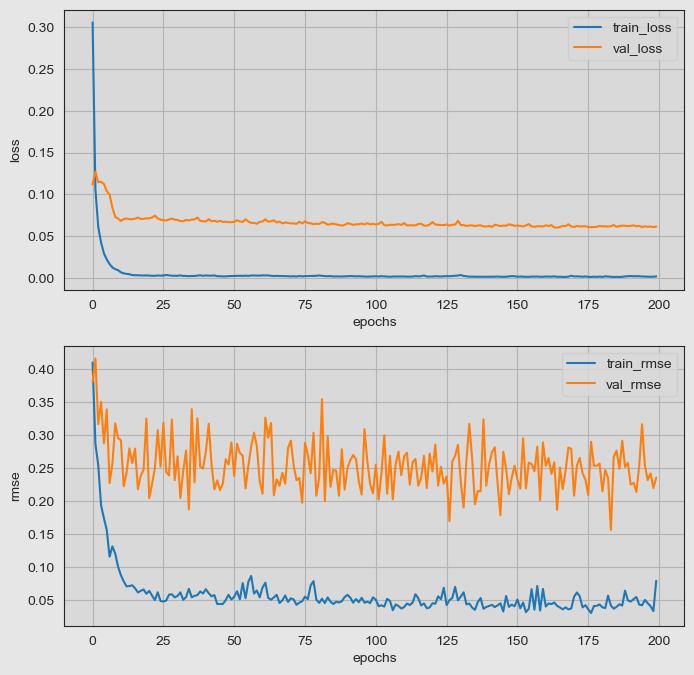

In [73]:
print_losses(base_history)

Обучим лучшую модель на 2000 эпохах с применением шедулера

In [69]:
net = MyNet_2_1_2()
loss_fn = nn.MSELoss()
optimizer_fn = optim.Adam(net.parameters(), lr=1e-3)
lr_scheduler_fn = lr_scheduler.StepLR(optimizer_fn, step_size=500, gamma=0.1)

best_net, history, rmse, loss = train(net, 
                                      loss_fn,
                                      optimizer_fn,
                                      train_nn_loader,
                                      valid_nn_loader,
                                      2000,
                                      lr_scheduler_fn,
                                      False)

epoch:   0%|          | 0/2000 [02:56<?, ?it/s]

best rmse 0.15715588629245758 on 934 epoch


Вывод по исследованию моделей:  

Лучший результат показала модель с архитектурой 512 -> 256 -> 1, функцией активации ReLU с BatchNorm, обученной на данных масштабированных с помощью Normalizer.  
Значение метрики RMSE на валидации равно 0.157

## 8. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Напишем функцию для получения эмбеддингов изображений и запросов из тестового датасета.

Напишем функцию для получения эмбеддингов изображений

In [31]:
def prepare_image(dataset, path_test_images):  
    dataset['path_image'] = dataset['image']. \
                            apply(lambda row: Path(path_test_images + '/test_images/' + row))
    
    dataset['query_image'] = [i[:-2] for i in dataset['query_id']]
    
    unique_image_test = pd.DataFrame(dataset['image'].unique(), columns=['image'])
    unique_image_test['path_image'] = [dataset[dataset['image'] == i]['path_image'].unique()[0]
                                       for i in unique_image_test['image']]
    
    transform_test_dataset = CustomDataset(unique_image_test, 'transform_image')
    embending_test_image = transorm_image(resnet, transform_test_dataset)

    return dataset, unique_image_test, embending_test_image

Получим тестовый датасет и эмбеддинги изображений.

In [74]:
test_dataset, unique_image_test, image_test_embendings = prepare_image(test_queries, DATA_PATH_LOCAL)

In [75]:
image_test_embendings.shape

(100, 512)

Напишем функцию для получения эмбеддингов запросов

In [32]:
def prepare_text(text, n=31):

    encoding_text = bert_tokenizer.batch_encode_plus([text],
                                                     padding=True,
                                                     truncation=True,
                                                     return_tensors='pt',
                                                     add_special_tokens=True)

    input_ids = encoding_text['input_ids'].numpy()[0].tolist() 
    attention_mask = encoding_text['attention_mask'].numpy()[0].tolist()

    input_ids_padded = np.array(input_ids + [0]*(n - len(input_ids)))
    attention_mask_padded = np.array(attention_mask + [0]*(n - len(attention_mask)))

    bert_model.eval()
    bert_model.to(DEVICE)

    token = torch.LongTensor([input_ids_padded])
    mask = torch.LongTensor([attention_mask_padded])
    token = token.to(DEVICE)
    mask = mask.to(DEVICE)
        
    with torch.set_grad_enabled(False):
        output = bert_model(token, attention_mask = mask)

    embendings = np.concatenate(output[0][:,0,:].cpu().numpy()) 
        
    bert_model.to('cpu')

    return embendings


Напишем функцию для объединения эмбеддингов запроса и всех уникальных тестовых изображений

In [77]:
def concat_embedding(e_text, e_images):
    image_query_test_embendings = np.zeros([e_images.shape[0], e_images.shape[1] + e_text.shape[0]])

    for i in range(e_images.shape[0]):

        i_image = e_images[i]
        image_query_test_embendings[i] = np.concatenate((i_image, e_text))

    image_query_test_embendings = image_query_test_embendings.astype('float32')
    image_query_test_embendings = norm_scaler.transform(image_query_test_embendings)

    return image_query_test_embendings

Напишем функцию для отрисовки предсказаний

In [33]:
def show_predict(dataset, predict_data, nrows, ncols, figsize):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                           sharey=True, sharex=True)
    
    i = 0
    for fig_x in ax.flatten():
        if predict_data[i][1] == 'Disc':
            imshow(DISC,
                   title=predict_data[i][0], 
                   plt_ax=fig_x)
            i += 1
        else:
            image, _ = dataset[predict_data[i][1]]
            query_n_estimate = predict_data[i][0] + '\n' + 'estimate:' + str(np.round(predict_data[i][2], 3))
    
            imshow(image.data.cpu(),
                   title=query_n_estimate, 
                   plt_ax=fig_x)
            i += 1

Напишем функцию для предсказания соответствия изображений запросу

In [34]:
def predict_target(model, X_test):
    model.eval()

    with torch.set_grad_enabled(False):
        outputs = model(torch.Tensor(X_test).to(DEVICE))

    predict = outputs.flatten().cpu().detach().numpy()

    return predict

Напишем функцию для предсказания картинок по запросу

In [35]:
def predict_image(text, image_embendings, model, n=31):
    
    lem_text = lemma(text)

    if not child_words.isdisjoint(set(lem_text.split(" "))):

        return [text, 'Disc', 0]
    
    else:
        text_embendings = prepare_text(lem_text, n=n) # Получаем эмбеддинг запроса
        image_query_embendings = concat_embedding(text_embendings, image_embendings) # Конкатенируем запрос с изображениями
        predictions = predict_target(model, image_query_embendings) # Получаем предсказания для всех картинок
        # Выводим список с текстом запроса, индексом картинки, оценкой соответствия
        return [text, predictions.argmax(), predictions[predictions.argmax()]] 

Получим предсказания для 10 случайных запросов из тестового датасета

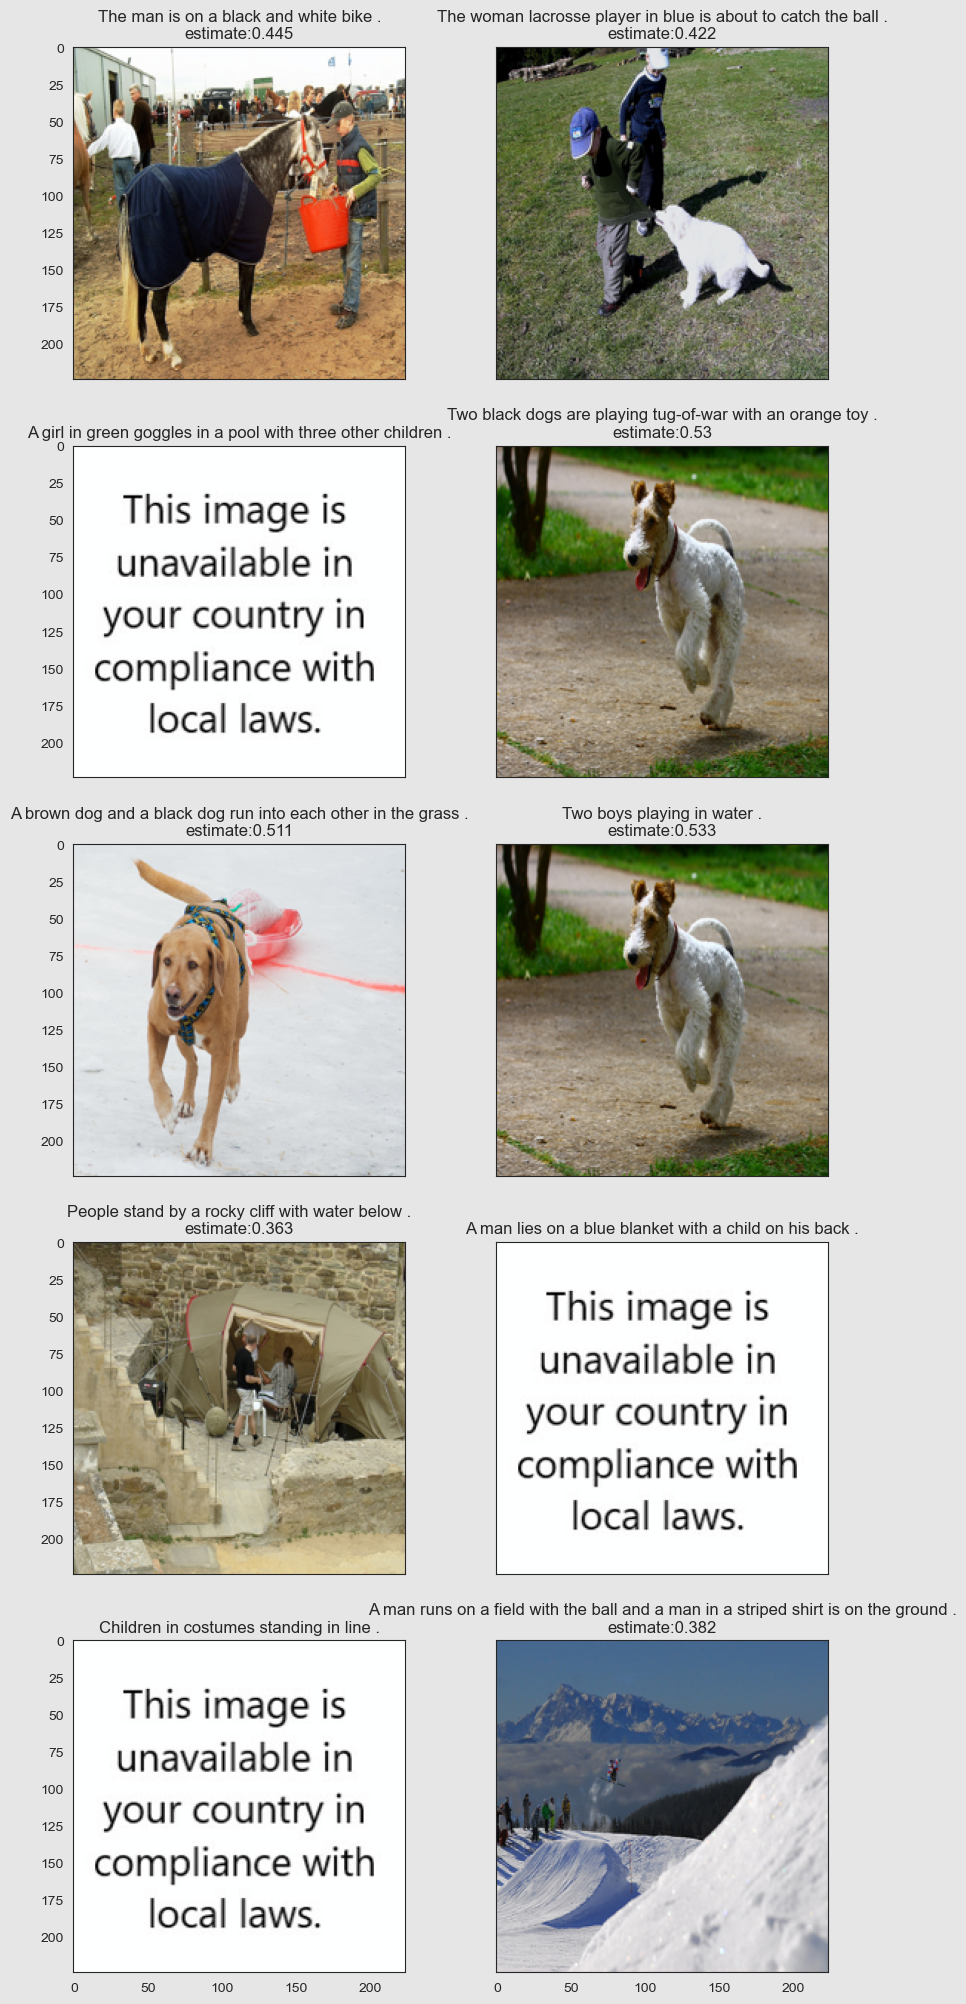

In [82]:
sample_1 = []
for i in range(10):
    text = test_dataset['query_text'].sample(1).values[0]
    sample_1.append(predict_image(
        text,
        image_test_embendings,
        best_net
    ))

image_query_test_df = CustomDataset(unique_image_test, mode='transform_image')
show_predict(image_query_test_df, sample_1, 5, 2, (10, 25)) 

Выводы по тестированию:  
- На запросы про детей выводится дисклеймер;
- Модель плохо подбирает изображения по запросу;
- Качество подбора в лучшем случае соответствует критерию "чистично подходит", то есть оценке экспертов 2; 
- Результат пока неудовлетворительный, необходимо рассмотреть другие модели.

## 9. Применение модели CLIP  

Так как рассмотренные выше модели показали неудовлетворительное качество поиска, попробуем применить предобученную нейросеть CLIP от OpenAI.

Загрузим версию модели clip-ViT-B-32

In [31]:
try:
    model_clip = SentenceTransformer(CLIP_PATH)
except:
    model_clip = SentenceTransformer("clip-ViT-B-32")

Напишем функции для получения эмбендингов изображений, поиска изображений по запросу и отображения результатов поиска

In [32]:
# функция для получения эмбендингов изображений
def prepare_image_clip(dataset, path_test_images):
    dataset['path_image'] = dataset['image']. \
                            apply(lambda row: Path(path_test_images + '/test_images/' + row))
    
    dataset['query_image'] = [i[:-2] for i in dataset['query_id']]
    
    unique_image_test = pd.DataFrame(dataset['image'].unique(), columns=['image'])
    unique_image_test['path_image'] = [dataset[dataset['image'] == i]['path_image'].unique()[0]
                                       for i in unique_image_test['image']]
    
    model_clip.to(DEVICE)
    embending_test_image_clip = model_clip.encode([Image.open(filepath) for filepath in unique_image_test.loc[:, 'path_image']], 
                                                  convert_to_tensor=True, 
                                                  show_progress_bar=True)

    return dataset, unique_image_test, embending_test_image_clip

Получим эмбендинги изображений с помощью модели CLIP 

In [33]:
test_dataset_clip, unique_image_test_clip, image_test_embendings_clip = prepare_image_clip(test_queries, DATA_PATH_LOCAL)
image_test_embendings_clip.shape

Batches: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


torch.Size([100, 512])

In [34]:
# функция поиска изображения по запросу
def search_image_clip(text:str, 
                       image_embendings:list):
    
    lem_text = lemma(text)

    if not child_words.isdisjoint(set(lem_text.split(" "))):

        return [text, 'Disc']
    
    else:
        text_embending = model_clip.encode([text], # Получаем эмбеддинг запроса
                                            convert_to_tensor=True, 
                                            show_progress_bar=False)
        hits = util.semantic_search(text_embending, # Получаем предсказания для всех картинок
                                    image_embendings, 
                                    top_k=1)[0]
        # Выводим список с текстом запроса, индексом картинки
        return [text, hits] 

In [41]:
# функция для отобрадения результатов поиска
def show_predict_clip(dataset:pd.DataFrame, 
                      predict_data:list,
                      nrows:int, 
                      ncols:int, 
                      figsize:tuple = (10, 25)):
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                           sharey=True, sharex=True)
    
    i = 0

    for fig_x in ax.flatten():
        if predict_data[i][1] == 'Disc':
            fig_x = ax.flatten()[i]
            imshow(DISC,
                   title=predict_data[i][0], 
                   plt_ax=fig_x)
            i += 1
        else:
            image, _ = dataset[predict_data[i][1][0]['corpus_id']]
            query_n_estimate = predict_data[i][0] + '\n' + 'estimate:' + str(np.round(predict_data[i][1][0]['score'], 3))

            fig_x = ax.flatten()[i]
            imshow(image.data.cpu(),
                   title=query_n_estimate, 
                   plt_ax=fig_x)
            i += 1

Протестируем модель CLIP

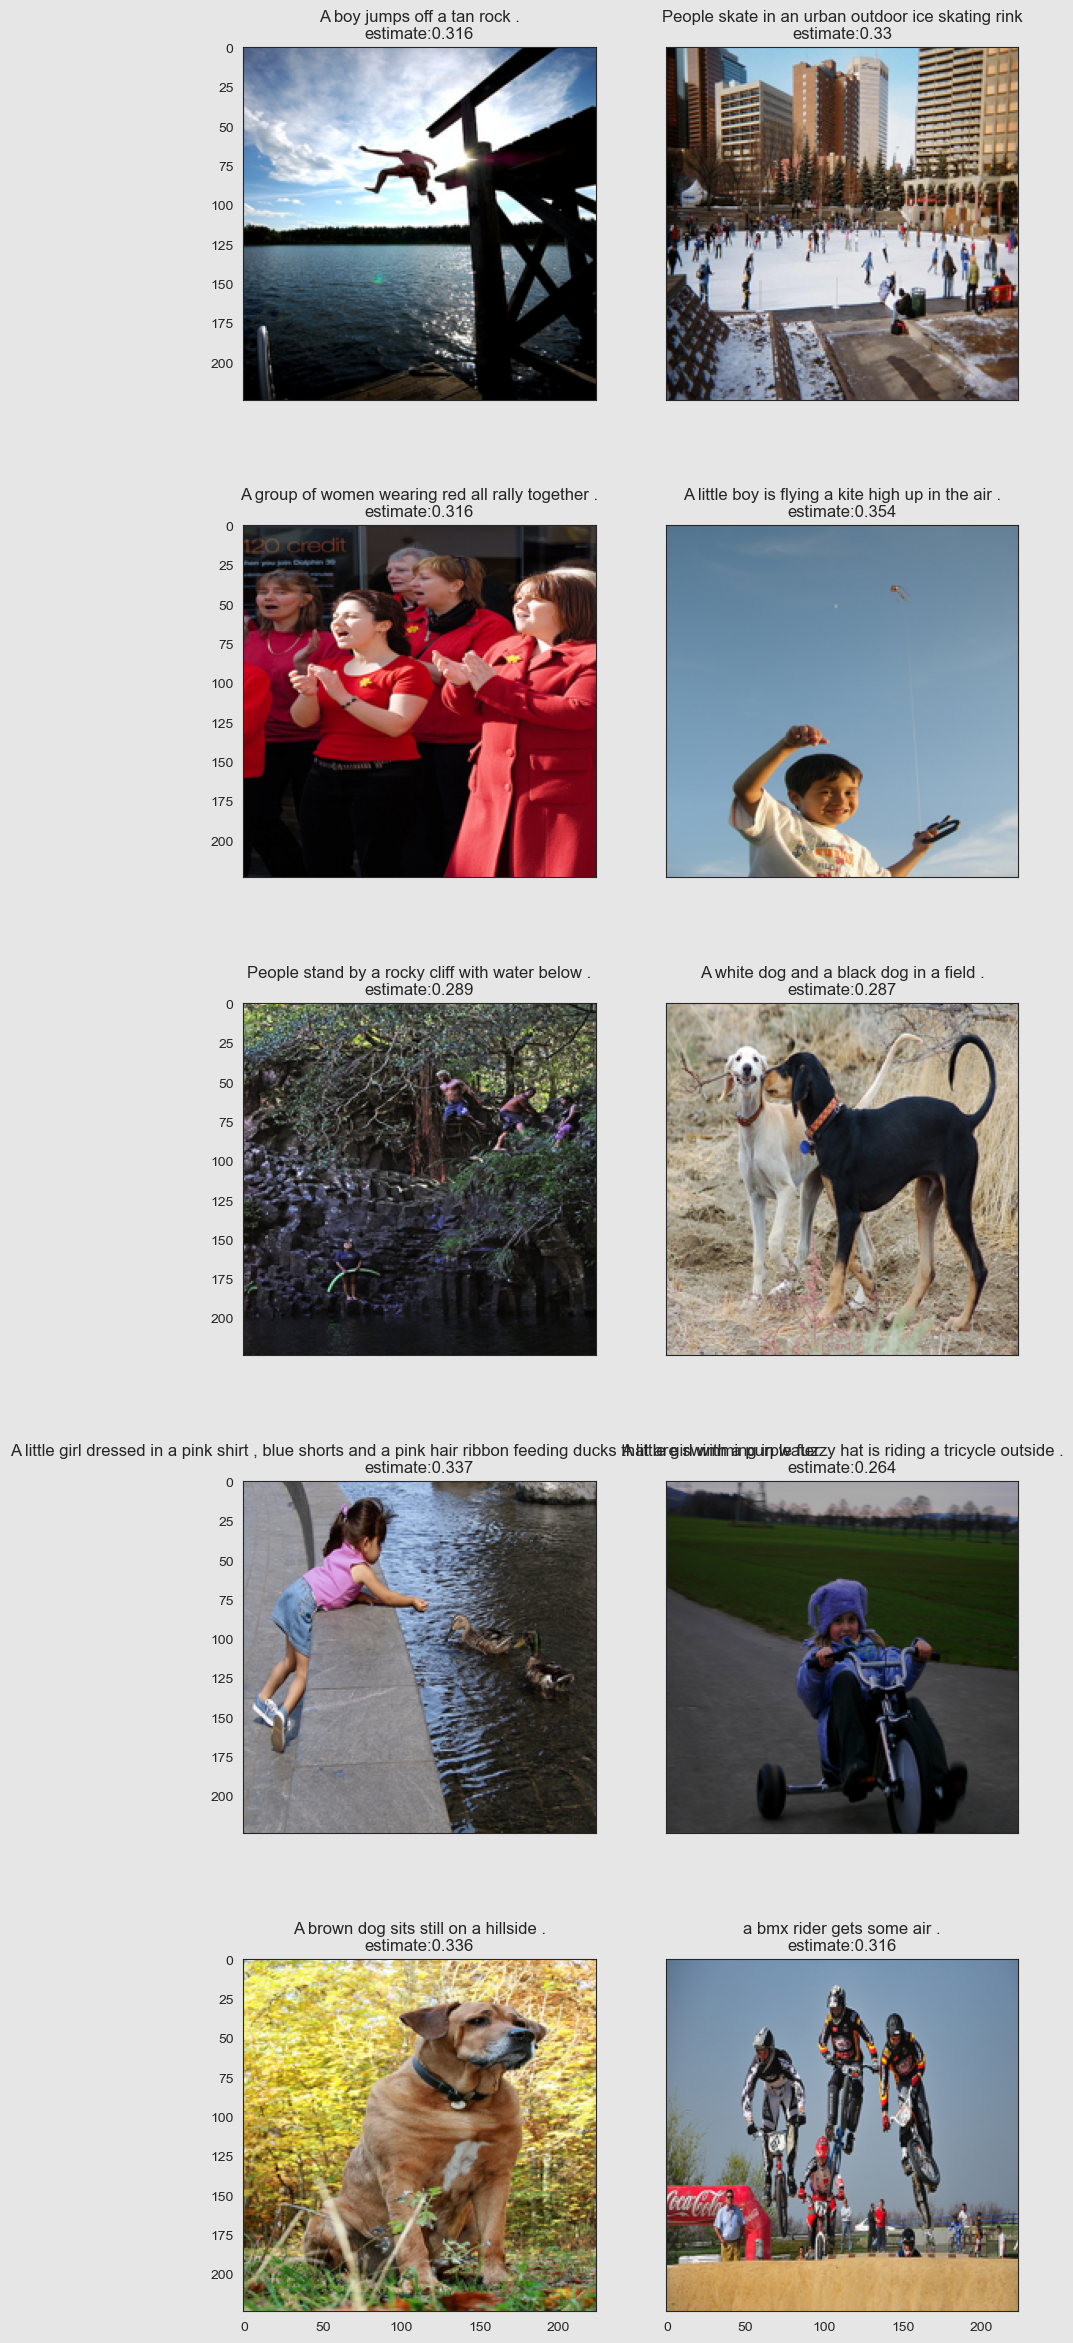

In [42]:
sample_1 = []
for i in range(10):
    text = test_dataset_clip['query_text'].sample(1).values[0]
    sample_1.append(search_image_clip(
        text,
        image_test_embendings_clip
    ))

image_query_test_df_clip = CustomDataset(unique_image_test_clip, mode='transform_image')
show_predict_clip(image_query_test_df_clip, sample_1, 5, 2, (10, 30))

Вывод по тестирования CLIP:  
модель CLIP практически идеально справляется с задачей поиска изображений по запросу. Необходимо доработать фильтрацию запросов про детей. В конечном итоге задача проекта выполнена. 

## 10. Выводы по проекту

Вывод по EDA:

- В тренировочном наборе данных имеем 5822 уникальных сочетаний картинок и запросов, 1000 уникальных картинов и 977 уникальных запросов;  
- В тестовом наборе данных имеем 500 уникальных сочетаний запросов и картинок, 500 уникальных запросов и 100 уникальных картинок, каждая картинка имеет 5 разных запросов;  
- Экспертные оценки полностью соответствуют обучающей выборке, всего оценок 5822;  
- Каждое сочетание картинка - запрос в обучающей выборке имеет 3 экспертные оценки;  
- Всего есть четыре варинта экспертных оценок: 1 - изображение полностью не соответствует запросу, 2 - изображение частично соответствует запросу, 3 - изображение частично не соответствует запросу, 4 - изображение полностью соответствует запросу;
- В экспертных оценках каждая картинка имеет как минимум две оценки соответствия;  
- Совокупная доля оценок 1, 2 составляет 85%, 3, 4 - 15%;
- Число оценок краудсорсинга составляет 47830;  
- Краудсорсинговые оценки обладают большей категоричностью, чем экспертные, и имеют два варинта соответствия: соответствует полностью или не соответствует вообще.  
- Также в краудсорсинговых оценках есть информация сколько людей посчитала, что изображение соответствует запросу, и сколько людей считает, что не соответствует;  
- Более чем в 87% случаев число людей, считающих, что изображение соответствет запросу, равно нулю.  
- Из визуального анализа картинок и запросов к ним из обучающего датасета можно сказать, что они крайне отличаются друг от друга в большинстве случаев, что скорее всего сделано для того, чтобы модель училась выявлять сложные зависимости между запросом и изображением.

Вывод по выбору таргета:  

Для обучения моделей в качестве таргета были выбраны экспертные оценки, поскольку они точнее описывают соответствие изображения запросу, что позволит модели точнее выучить зависимость и быть болеее гибкой.

Вывод по преобразованию экспертных оценок:

Каждые три экспертные оценки для соответствующего сочетания картинка - запрос были агрегированы методом большинства и отшкалированы с помощью линейного преобразования (х-1)/3.  
Тренировочный набор данных был объединен с набор экспертных оценок по двум колонкам image и query_id.  

Вывод по фильтрации датасета:  
Из обучающего датасета были удалены все запросы связанные с детьми и все изображения, на которых согласно соответствующих им запросов были изображены дети. Всего было удаленно 98 уникальных запросов и 98 соответствующих им картинок.  

Веторизация изображений:
Изображения были векторизированы с помощью сети ResNet18.  
Итоговая размерность веткора изображения составила 512 элементов.  

Векторизация запросов:  
Запросы были векторизированы с помощью трансформера Bert.  
Размер каждого вектора составил 768 значений.  

Вывод по обучению моделей:  
Датасет был разделен на тренировочную и валидационную выборки с помощью [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.  

Исследовались два типа моделей:  
- Линейная регрессия
- Полносвязанная нейронная сеть.  

Качество предсказания соответствия оценивалось по метрики RMSE.  

Лучший результат показала полносвязная нейронная сеть с архитектурой 512 -> 256 -> 1, функцией активации ReLU с BatchNorm, обученной на данных масштабированных с помощью Normalizer.  
Значение метрики RMSE на валидации составило 0.157.  

Вывод по тестированию лучшей модели:  
- На запросы про детей выводится дисклеймер;
- Модель плохо подбирает изображения по запросу;
- Качество подбора в лучшем случае соответствует критерию "чистично подходит", то есть оценке экспертов 2; 
- Результат неудовлетворительный, необходимо рассмотреть другие модели.  

Вывод по тестированию CLIP:  
Применение предобученной модели CLIP от OpenAI позволи существенно повысить визуальное качество поиска изображений по запросу. предсказанные изображения практически точно соответствуют тексту запроса. Большим плюсом является то, что нет необходимости дообучать данную модель, она прекрасно справляется с задачей "из коробки".  
